In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import linprog
import folium


sites_file = "Data-partie-1/Sites.csv"
onshore_file = "Data-partie-1/Rendements_onshore.csv"
offshore_file = "Data-partie-1/Rendements_offshore.csv"

P = 500000
k = 0.17

In [2]:
df = pd.read_csv(sites_file, skiprows=1, header=None)

data = df.values

onshore_capacity = np.array([i[7] for i in data if i[5] == "Non"], dtype=np.float64)
offshore_capacity = np.array([i[7] for i in data if i[5] == "Oui"], dtype=np.float64)
n_onshore = len(onshore_capacity)
n_offshore = len(offshore_capacity)
n = n_onshore+n_offshore

df_onshore = pd.read_csv(onshore_file, header=None)
df_offshore = pd.read_csv(offshore_file, header=None)

onshore_data = df_onshore.values
offshore_data = df_offshore.values

onshore_indices = np.where(data[:, 5] == "Non")[0]
offshore_indices = np.where(data[:, 5] == "Oui")[0]

onshore_yield = onshore_data[onshore_indices].astype(np.float64)
offshore_yield = offshore_data[offshore_indices].astype(np.float64)

In [3]:
T = np.shape(onshore_yield)[1]
C = np.concatenate((onshore_capacity, offshore_capacity))
Y = np.concatenate((onshore_yield, offshore_yield))
E = C[:, np.newaxis] * Y

In [4]:
obj_func_coeffs = np.concatenate((np.zeros(n), [-1]))

i_matrix = np.concatenate((
    np.hstack((np.concatenate((np.identity(n), -np.identity(n))), np.zeros((2 * n, 1)))),
    np.hstack((-np.transpose(E), np.ones((T, 1))))
))
i_vector = np.concatenate((
    np.ones(n),
    np.zeros(n + T)
))

e_matrix = np.array([
    np.concatenate((C, [0])),
    np.concatenate((np.zeros(n_onshore), offshore_capacity, [0]))
])
e_vector = np.array([P, k * P])

solution = linprog(c=obj_func_coeffs, A_ub=i_matrix, b_ub=i_vector, A_eq=e_matrix, b_eq=e_vector)

print(len(i_vector),n,T)

S = solution.x[:n]
M = -solution.fun

10044 642 8760


In [5]:
E_produced = np.zeros(T)
Yield = np.zeros(T)

for j in range(T):
    E_produced[j] = np.dot(S, E[:, j])
    Yield[j] = np.dot(S, Y[:, j]) / np.sum(S)

E_total = np.sum(E_produced)
Yield_avg = np.mean(Yield)


In [6]:
latitude = [i[1] for i in data]
longitude = [i[2] for i in data]
country = [i[3] for i in data]
color = [i[4] for i in data]

latitude = pd.to_numeric(latitude, errors='coerce')
longitude = pd.to_numeric(longitude, errors='coerce')

valid_indices = np.where(~np.isnan(latitude) & ~np.isnan(longitude))
latitude = latitude[valid_indices]
longitude = longitude[valid_indices]
color = np.array(color)[valid_indices]

In [7]:
m = folium.Map(location=[np.median(latitude), np.median(longitude)], zoom_start=3)


size = 4
# Add points to the map
for idx in range(len(latitude)):
    if S[idx] == 0:
        continue
    folium.CircleMarker(
        location=[latitude[idx], longitude[idx]],
        radius=size * S[idx], 
        color=color[idx],
        fill=True,
        fill_color=color[idx],
        fill_opacity=1.0 
    ).add_to(m)

m.save(outfile="map.html")
display(m)

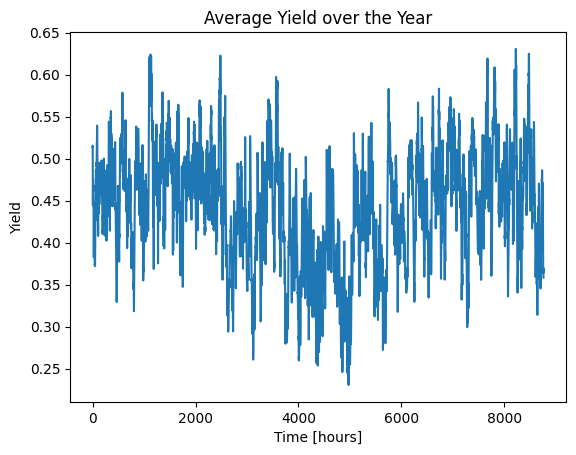

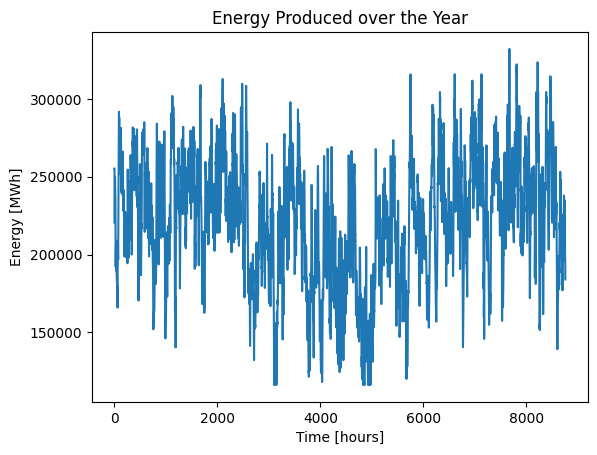

In [8]:
plt.plot(Yield)
plt.xlabel('Time [hours]')
plt.ylabel('Yield')
plt.title('Average Yield over the Year')
plt.savefig('average_yield.png')
plt.show()


plt.plot(E_produced)
plt.xlabel('Time [hours]')
plt.ylabel('Energy [MWh]')
plt.title('Energy Produced over the Year')
plt.savefig('energy_produced.png')
plt.show()

In [9]:
windmills_used = sum(S)

print(f"Minimum energy produced in one hour: {M} MWh")
print(f"Average annual yield: {Yield_avg*100}%")
print(f"Energy produced in one year: {E_total} MWH")
print(f"Amount of windmills used: {windmills_used}")

Minimum energy produced in one hour: 116226.59223094779 MWh
Average annual yield: 44.166513759219114%
Energy produced in one year: 1945870075.4489331 MWH
Amount of windmills used: 266.95540938960335


#Q2

In [10]:
T = np.shape(onshore_yield)[1]
C = np.concatenate((onshore_capacity, offshore_capacity))
Y = np.concatenate((onshore_yield, offshore_yield))
E = C[:, np.newaxis] * Y

In [11]:
def solver2(A_max):
    A = np.zeros(T)


    obj_func_coeffs = np.concatenate((np.zeros(n+T), [-1]))

    i_matrix = np.concatenate((
        np.hstack((np.concatenate((np.identity(n), -np.identity(n))), np.zeros((2 * n, T+1)))),
        np.hstack((-np.transpose(E), -np.identity(T),np.ones((T, 1)))),
        np.hstack((np.zeros((T,n)),-np.identity(T),np.zeros((T,1)))),
        np.hstack((np.zeros((1,n)),np.ones((1,T)),np.zeros((1,1))))
    ))
    i_vector = np.concatenate((
        np.ones(n),
        np.zeros(shape=n),
        np.zeros(2*T),
        [A_max]
    ))

    e_matrix = np.array([
        np.concatenate((C, np.zeros(T),[0])),
        np.concatenate((np.zeros(n_onshore), offshore_capacity,np.zeros(T+1)))
    ])
    e_vector = np.array([P, k * P])


    solution = linprog(c=obj_func_coeffs, A_ub=i_matrix, b_ub=i_vector, A_eq=e_matrix, b_eq=e_vector)

    S = solution.x[:n]
    A = solution.x[n:-1]
    M = -solution.fun
    print(M,sum(A))
    return S,A,M

energy_bought = 25000
S,A,M = solver2(energy_bought)

118227.33424126249 24999.99999999975


In [12]:
E_produced = np.zeros(T)
Yield = np.zeros(T)

for j in range(T):
    E_produced[j] = np.dot(S, E[:, j])
    Yield[j] = np.dot(S, Y[:, j]) / np.sum(S)

E_total = np.sum(E_produced)
Yield_avg = np.mean(Yield)

In [13]:
latitude = [i[1] for i in data]
longitude = [i[2] for i in data]
country = [i[3] for i in data]
color = [i[4] for i in data]

latitude = pd.to_numeric(latitude, errors='coerce')
longitude = pd.to_numeric(longitude, errors='coerce')

valid_indices = np.where(~np.isnan(latitude) & ~np.isnan(longitude))
latitude = latitude[valid_indices]
longitude = longitude[valid_indices]
color = np.array(color)[valid_indices]

In [14]:
m = folium.Map(location=[np.median(latitude), np.median(longitude)], zoom_start=3)

size = 4
# Add points to the map
for idx in range(len(latitude)):
    if S[idx] == 0:
        continue
    folium.CircleMarker(
        location=[latitude[idx], longitude[idx]],
        radius=size * S[idx], 
        color=color[idx],
        fill=True,
        fill_color=color[idx],
        fill_opacity=1.0 
    ).add_to(m)

m.save(outfile="map_Q2.html")
display(m)

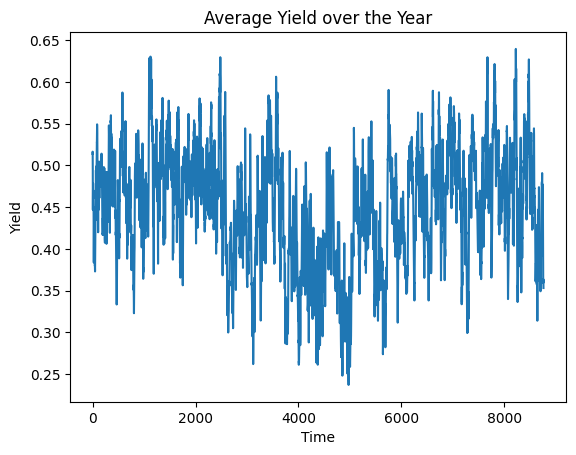

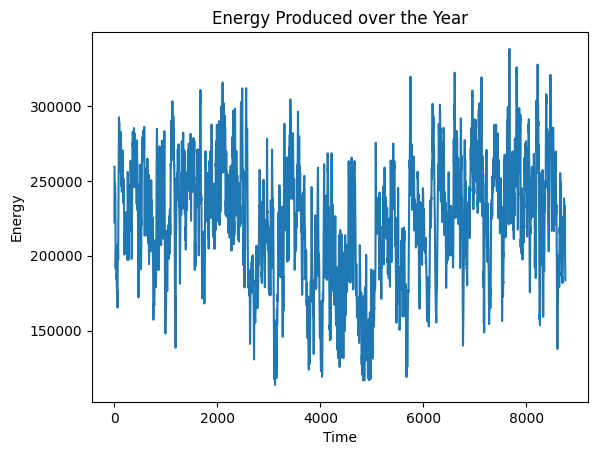

In [15]:
plt.plot(Yield)
plt.xlabel('Time')
plt.ylabel('Yield')
plt.title('Average Yield over the Year')
plt.savefig('average_yield_Q2.png')
plt.show()


plt.plot(E_produced)
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy Produced over the Year')
plt.savefig('energy_produced_Q2.png')
plt.show()

In [16]:
windmills_used = sum(S)
print("Energy bought: {sum(A)} MWh")
print(f"Minimum energy produced in one hour: {M} MWh")
print(f"Average annual yield: {Yield_avg*100}%")
print(f"Energy produced in one year: {E_total} MWH")
print(f"Amount of windmills used: {windmills_used}")

Energy bought: {sum(A)} MWh
Minimum energy produced in one hour: 118227.33424126249 MWh
Average annual yield: 44.89832092496014%
Energy produced in one year: 1961434025.4323967 MWH
Amount of windmills used: 260.4471320186881


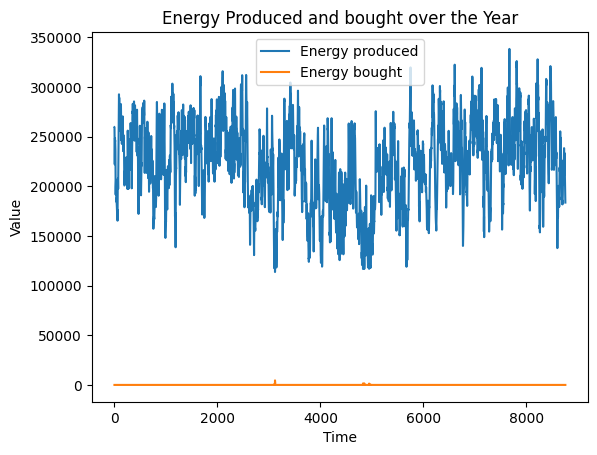

In [17]:
plt.plot(E_produced, label='Energy produced')
plt.plot(A, label='Energy bought')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Energy Produced and bought over the Year')
plt.legend()
plt.savefig('energy_produced_and_Bought.png')
plt.show()


In [18]:
percentage_bought = 0.1

steps = 20
E_list = np.zeros(steps+1)
E_bought = np.zeros(steps+1)
for i in range(0,steps+1):
    energy_bought = i/steps * P
    S,A,M = solver2(energy_bought)
    E_list[i] = M
    E_bought[i] = sum(A)

116226.59223094779 0.0
118227.33424126249 24999.99999999975
119314.88003709556 50000.00000000001
120193.67660621167 74999.99999999967
120942.6068309315 99999.99999999942
121612.99775699466 124999.9999999987
122226.78412182258 150000.00000000084
122768.44058985959 174999.9999999999
123268.62391942777 199999.9999999989
123739.62993353984 225000.0000000007
124197.09389721326 250000.00000000116
124634.2218989386 274999.99999999744
125052.48314491686 300000.00000000204
125459.49253729348 325000.0000000004
125844.53722500308 349999.99999999936
126218.44883592516 375000.00000000274
126580.210159849 400000.00000000064
126934.80683717462 425000.0000000013
127282.93075895583 449999.9999999984
127621.56483127906 475000.00000000047
127942.07781435289 499999.99999999837


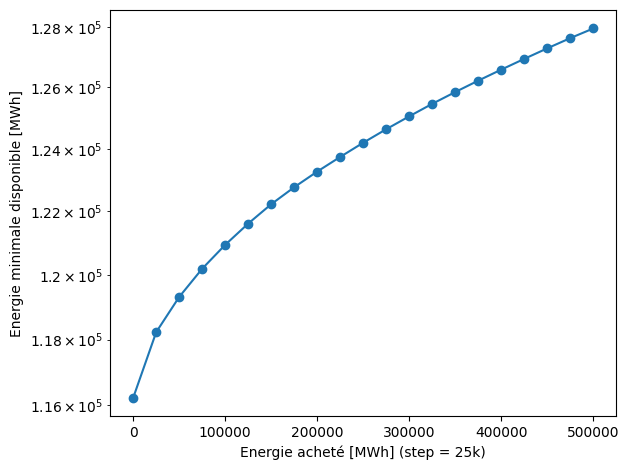

In [19]:

plt.semilogy(E_bought, E_list, 'o-')
plt.title('')
plt.xlabel('Energie acheté [MWh] (step = 25k)')
plt.ylabel('Energie minimale disponible [MWh]')
plt.tight_layout()
plt.savefig('energy_bought_vs_minimal_energy.png')
plt.show()
